In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller, coint
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.tsa.api import VECM

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Monthly Financial Time Series Data : USA Housing Market Factors 

In [17]:
dataset_path = r"https://raw.githubusercontent.com/Karanpalshekhawat/world-quant-mfe/main/Monthly_Macroeconomic_Factors.csv"
df = pd.read_csv(dataset_path, parse_dates=["Date"])
df = df.set_index('Date')
df = df[:'2019'] # limiting data till 2019 to avoid covid window

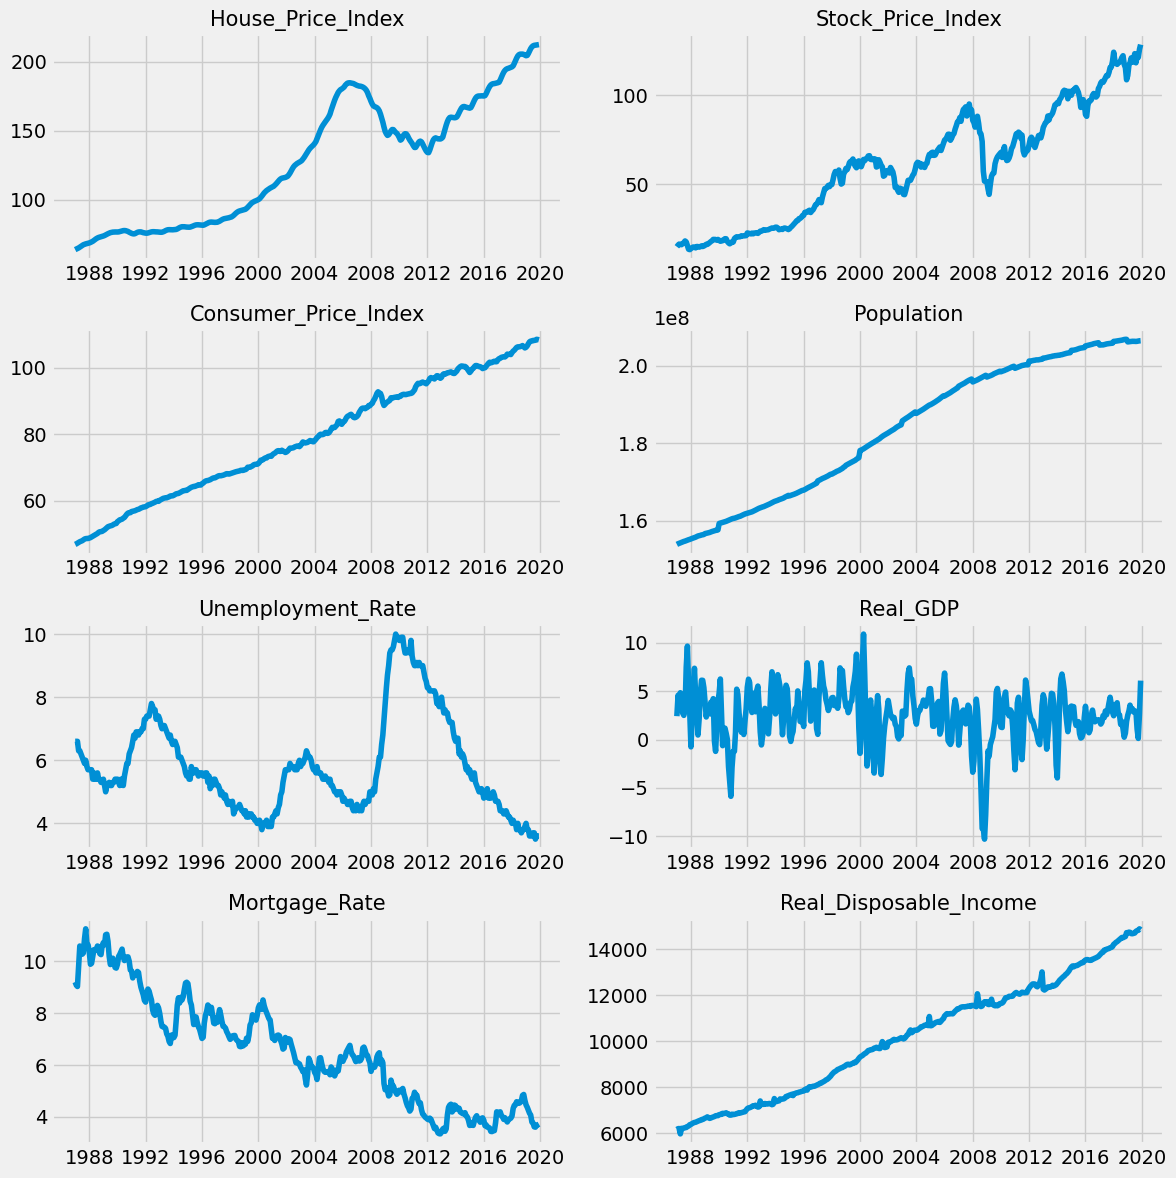

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes[0, 0].plot(df.index, df['House_Price_Index'])
axes[0, 1].plot(df.index, df['Stock_Price_Index'])
axes[1, 0].plot(df.index, df['Consumer_Price_Index'])
axes[1, 1].plot(df.index, df['Population'])
axes[2, 0].plot(df.index, df['Unemployment_Rate'])
axes[2, 1].plot(df.index, df['Real_GDP'])
axes[3, 0].plot(df.index, df['Mortgage_Rate'])
axes[3, 1].plot(df.index, df['Real_Disposable_Income'])

# Add titles and labels
axes[0, 0].set_title('House_Price_Index', fontsize=15)
axes[0, 1].set_title('Stock_Price_Index', fontsize=15)
axes[1, 0].set_title('Consumer_Price_Index', fontsize=15)
axes[1, 1].set_title('Population', fontsize=15)
axes[2, 0].set_title('Unemployment_Rate', fontsize=15)
axes[2, 1].set_title('Real_GDP', fontsize=15)
axes[3, 0].set_title('Mortgage_Rate', fontsize=15)
axes[3, 1].set_title('Real_Disposable_Income', fontsize=15)
plt.tight_layout()
plt.show()

### Stationarity Tests for all market factors : Visually all look Non Stationary

In [4]:
p_values_dict = {}
for col in df.columns:
    adf_test = adfuller(df[col].values, regression="n")
    p_values_dict[col] = adf_test[1]

In [5]:
df_pvalue = pd.DataFrame(p_values_dict.items(), columns=['Time Series Name', 'P-Value'])
df_pvalue

,Time Series Name,P-Value
0,House_Price_Index,0.948614
1,Stock_Price_Index,0.983592
2,Consumer_Price_Index,1.000000
3,Population,1.000000
4,Unemployment_Rate,0.360325
5,Real_GDP,0.012550
6,Mortgage_Rate,0.052258
7,Real_Disposable_Income,1.000000


### We ran ADF test assuming no constant and no trend i.e. directly on the time series.

### As p-value for all financial time series (apart from Real GDP) is greater than 0.05, it means that we cannot reject the Null hypothesis that is there is a presence of unit root implying all of them are Non-Stationary apart from Real GDP.

---

### Seasonal Analysis

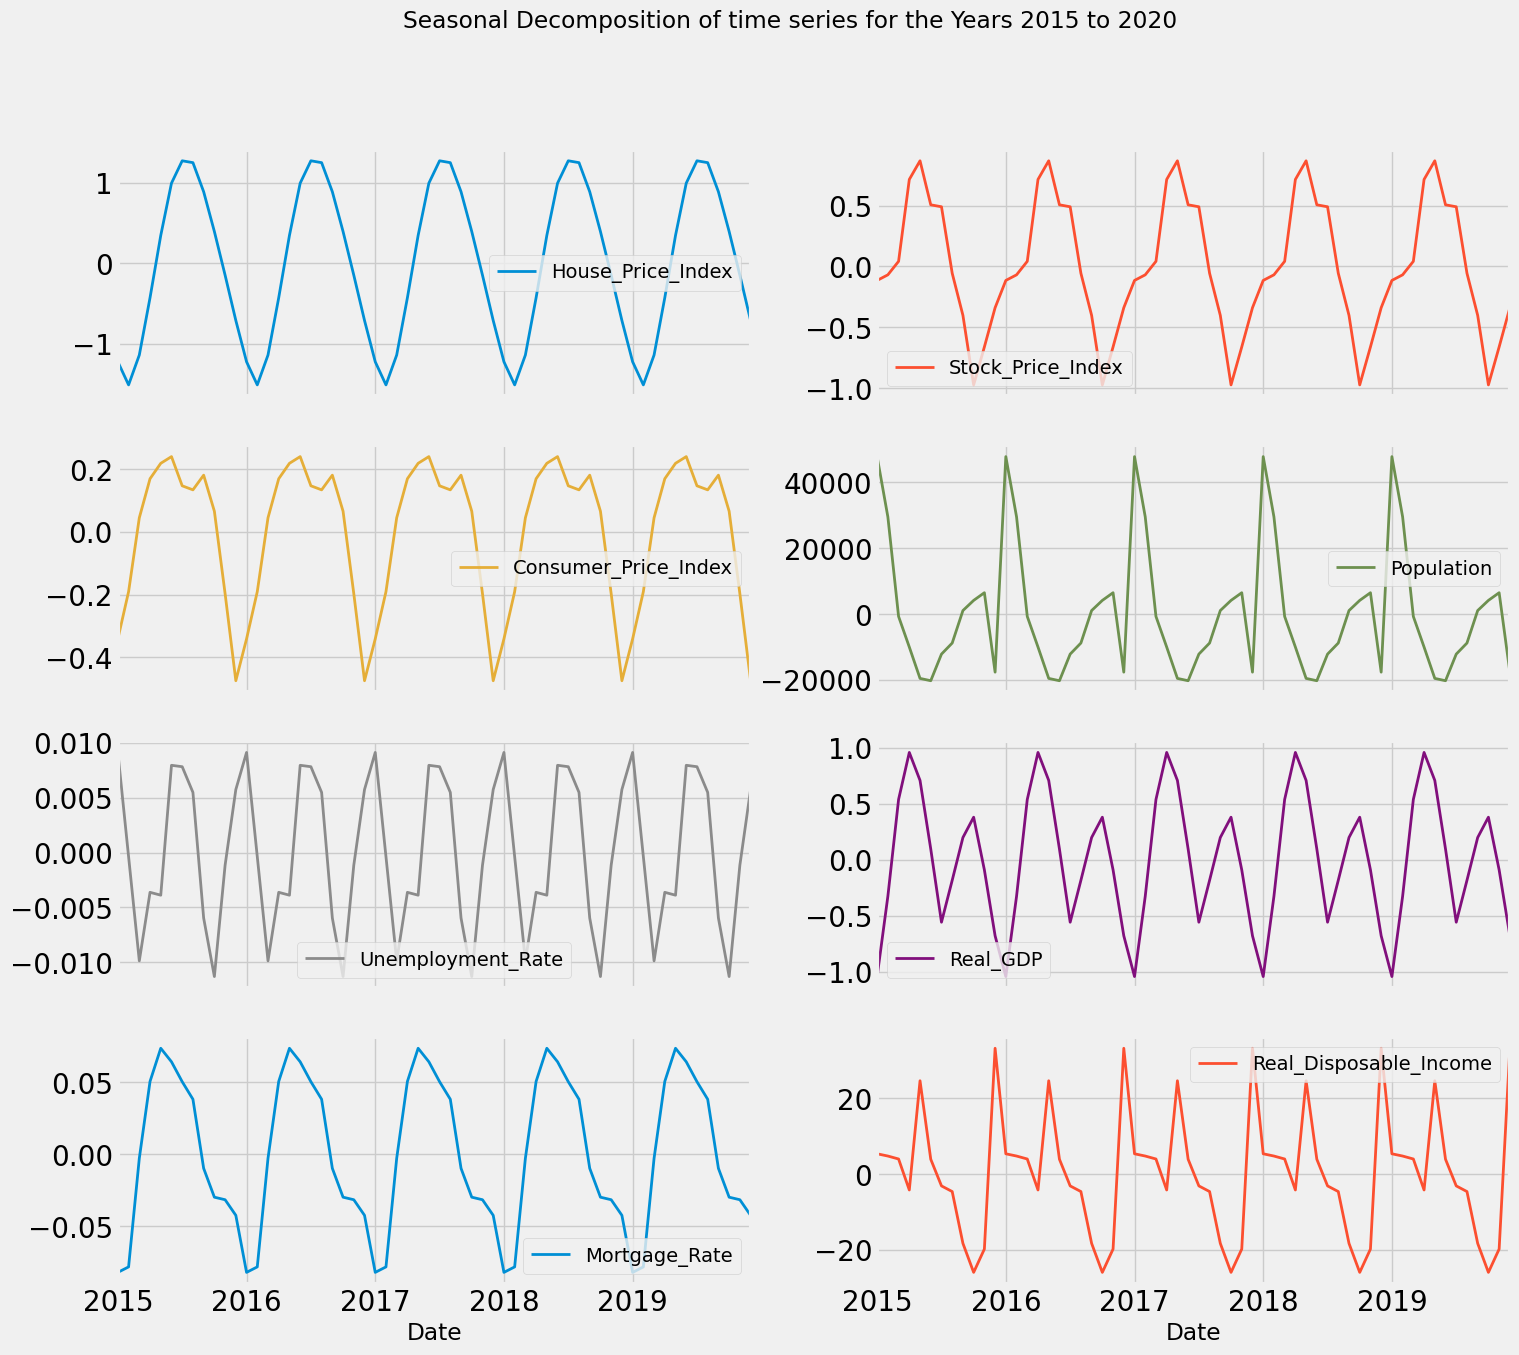

In [6]:
seasonality_dict = {}

for ts in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[ts].dropna())
    # Store the results back
    seasonality_dict[ts] = decompositions.seasonal

# Plot
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(seasonality_dict)["2015":"2020"].plot(subplots=True, layout=(4, 2), linewidth=2, title="Seasonal Decomposition of time series for the Years 2015 to 2020", fontsize=20)
plt.show()

### As expected for all time series, we can see that there is some kind of seasonal trend

---
### Trend Analysis

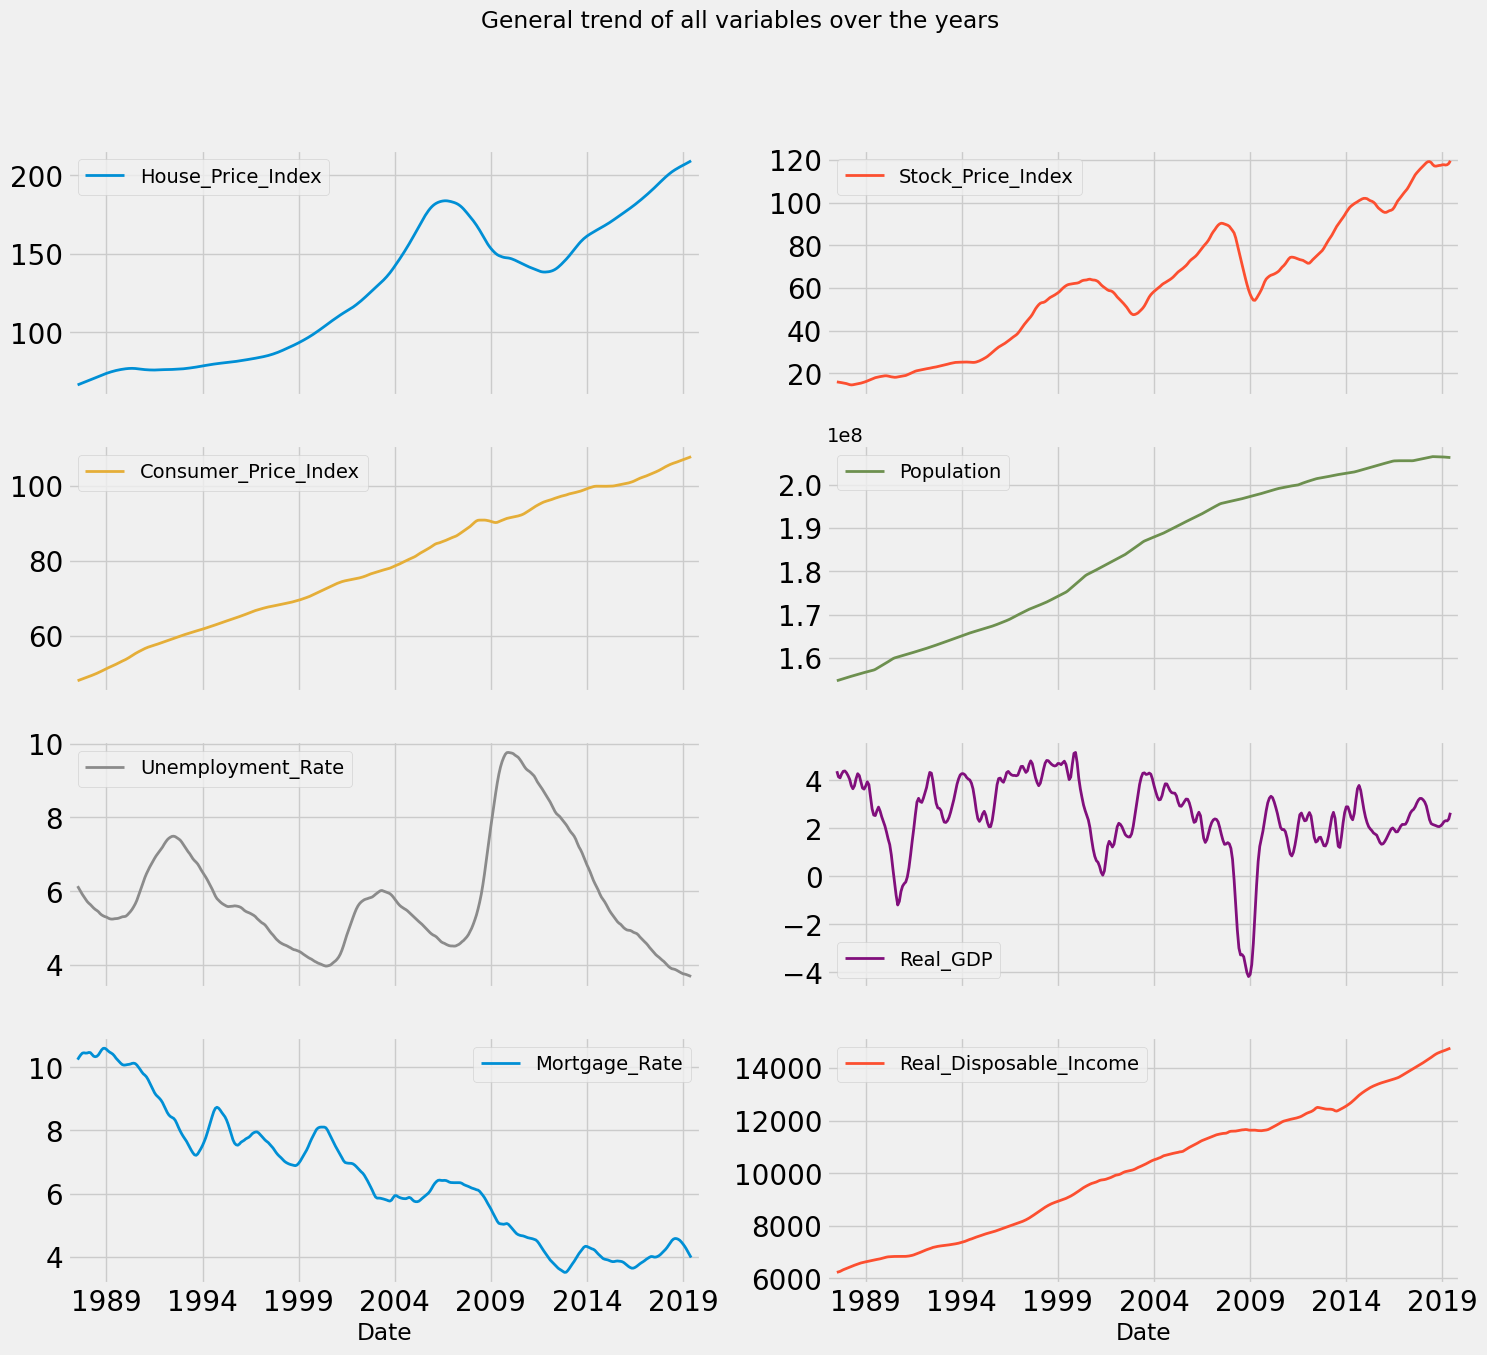

In [19]:
trend_dict = {}

for ts in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[ts].dropna())
    # Store the results back
    trend_dict[ts] = decompositions.trend

# Plot
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(trend_dict).plot(subplots=True, layout=(4, 2), linewidth=2, title="General trend of all variables over the years", fontsize=20)
plt.show()

### As expected for all time series apart from Real GDP, we can see kind of trend either increasing or decreasing. Note that Unemployment rate seems to behave like a cyclical series over the longer term.

---

### Residuals : Random Noise


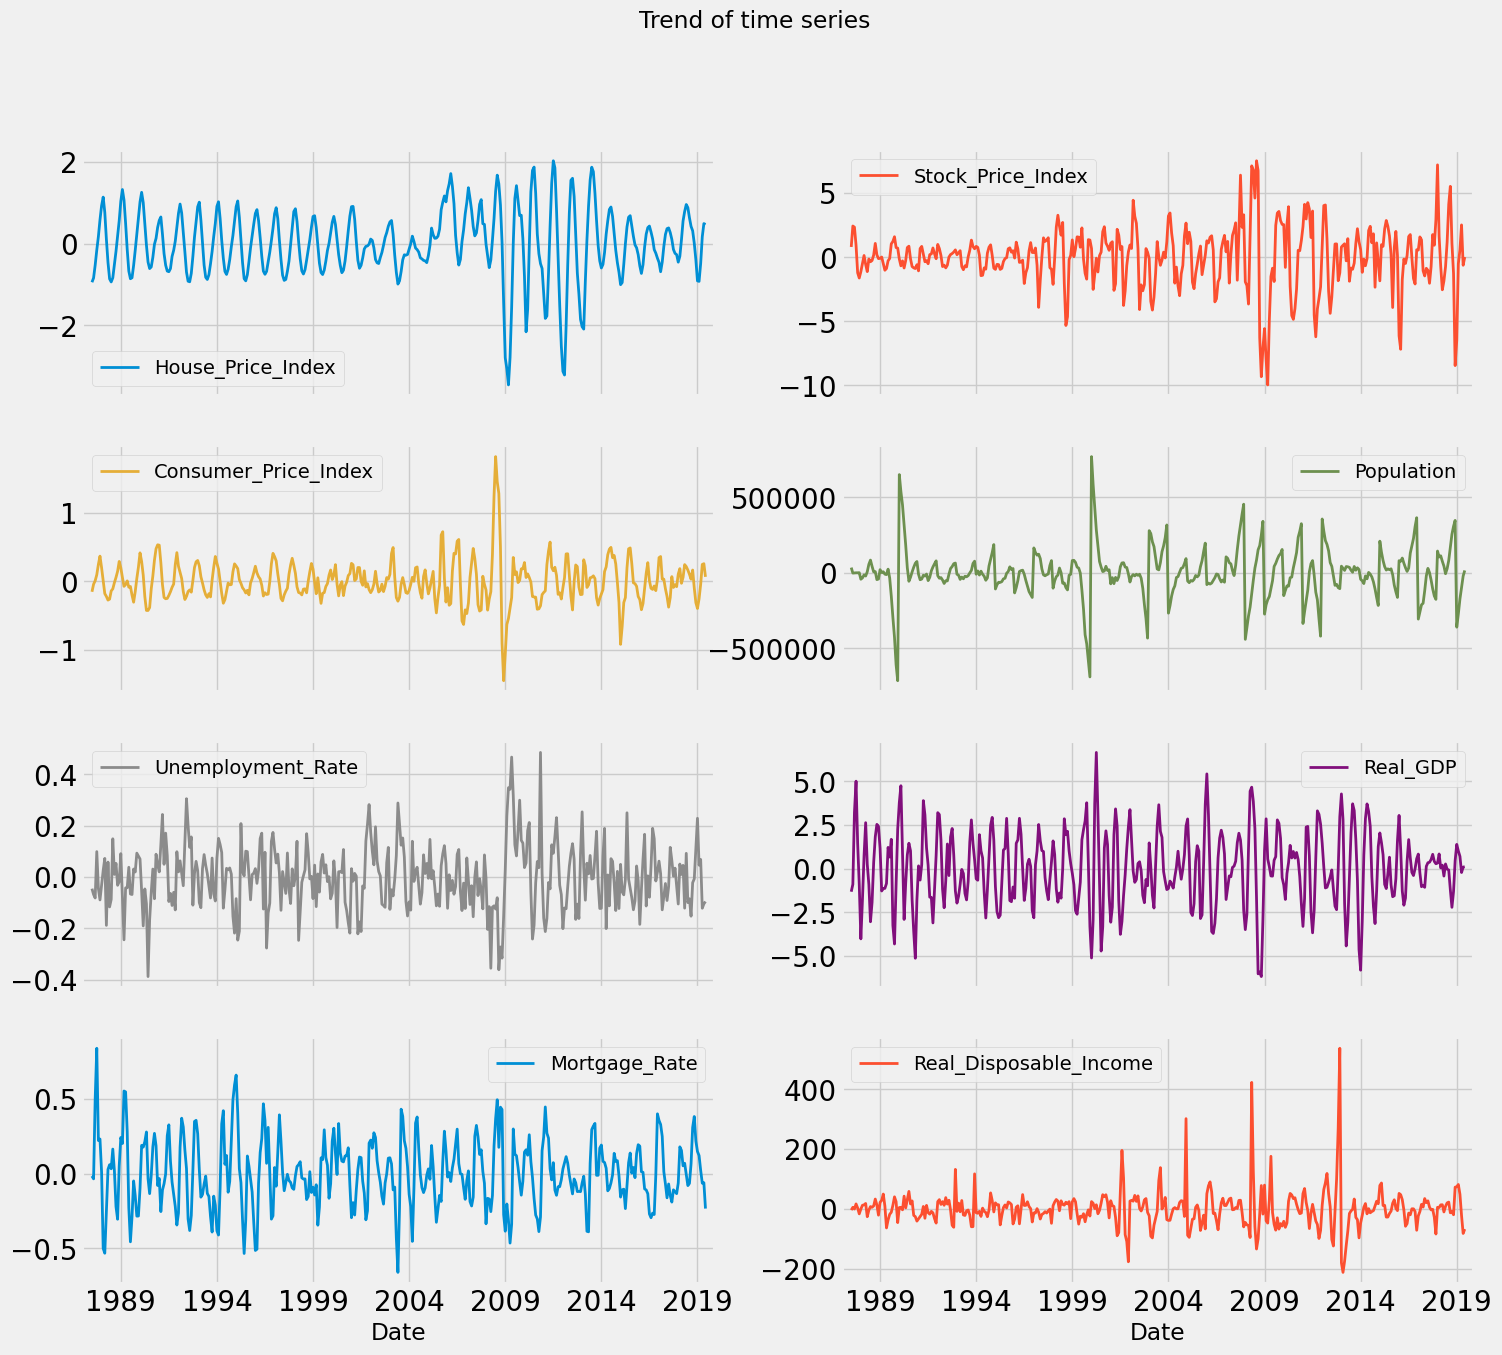

In [8]:
resid_dict = {}

for ts in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[ts].dropna())
    # Store the results back
    resid_dict[ts] = decompositions.resid

# Plot
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(resid_dict).plot(subplots=True, layout=(4, 2), linewidth=2, title="Trend of time series", fontsize=20)
plt.show()

### As expected, noise analysis does not shows anything fancy about the time series, it only shows regular random components that cannot be attributed to either seasonality or trend.

---
### Growth Analysis : Normalizing Scales

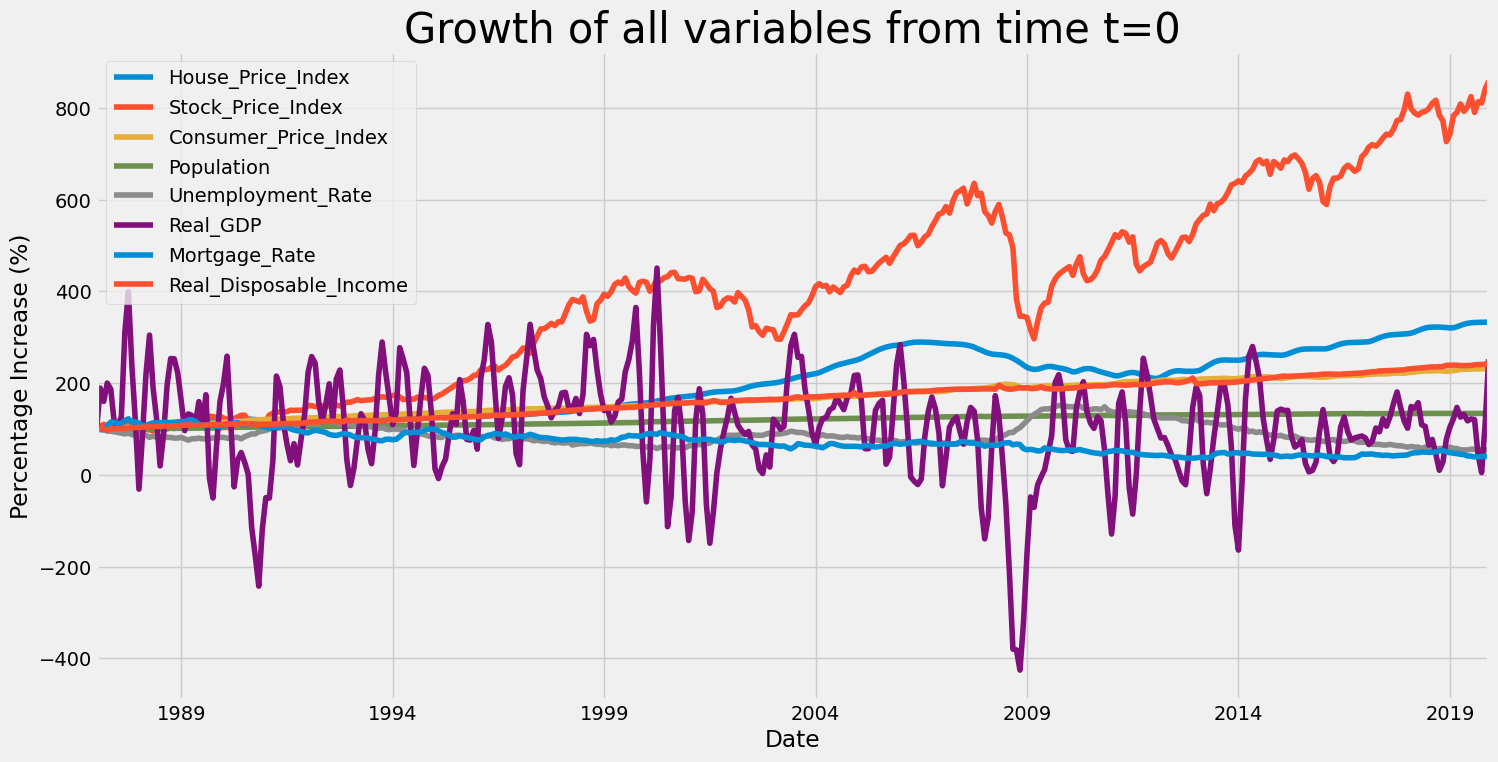

In [9]:
normalized = df.div(df.iloc[0]).mul(100)  # Multiply by 100 to get percentages

normalized.plot(figsize=(16, 8))
plt.title("Growth of all variables from time t=0", fontsize=30)
plt.xlabel("Date")
plt.ylabel("Percentage Increase (%)");

### Real Disposable income has the highest growth, Real GDP growth is the most fluctuated while mortgage rate showed the decreasing trend

---

### Relationship between time series with correlation

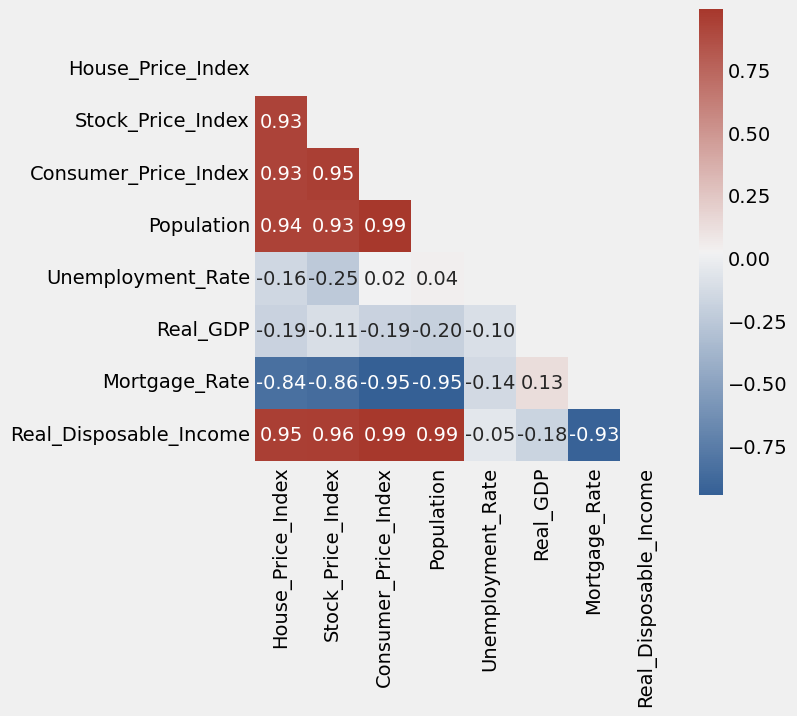

In [21]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = df.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

### Correlation does not imply causation : there is a chance that some of the time series are cointegrated to each other i.e. they might be increasing just because of other factors like time and may not have actual relationship between each other. One counter example can be real disposable income  and mortgage rate seems to have negative correlation which seems to make sense. 

---

### Although VAR model can handle non-stationarity directly in the model but it will still need some tweak

### Spurious regression: if there are co-integrated time series, better to fit vector error correction model which adjusts short run dynamics to converge to long term equilibrium relationship

# <strong> <a style="color:red">Problem Statement: Fit VaR Model on House Price Index using all variables</a> </strong> 

---

## <strong> <a style="color:blue">Co-Integration and Error Correction Model</a> </strong> 

### Engle-granger 2 step procedure to test for Co-Integration

#### First Step: To check if all time series are I(1)

In [11]:
p_values_diff_dict = {}
for col in df.columns:
    adf_test = adfuller(df[col].diff().dropna().values, regression="n")
    p_values_diff_dict[col] = adf_test[1]
df_pvalue_diff = pd.DataFrame(p_values_diff_dict.items(), columns=['Time Series Name (First difference)', 'P-Value'])
df_pvalue_diff

,Time Series Name (First difference),P-Value
0,House_Price_Index,1.520806e-02
1,Stock_Price_Index,2.059570e-08
2,Consumer_Price_Index,2.704114e-02
3,Population,5.679339e-02
4,Unemployment_Rate,4.504177e-05
5,Real_GDP,1.511831e-20
6,Mortgage_Rate,1.448180e-19
7,Real_Disposable_Income,8.625814e-03


### All are I(1) as p-value is less than < 0.05

In [12]:
df_cointegration = pd.DataFrame(columns=['First Factor', 'Second Factor', 'P-value'])
i=0
for col1 in df.columns:
    for col2 in df.columns:
        if col1 != col2:
            p_value = coint(df[col1], df[col2], trend="c", method="aeg")[1]
            df_cointegration.loc[i] = [col1, col2, p_value]
            i+=1           

In [13]:
df_cointegration[df_cointegration['First Factor'] == 'House_Price_Index']

,First Factor,Second Factor,P-value
0,House_Price_Index,Stock_Price_Index,0.619005
1,House_Price_Index,Consumer_Price_Index,0.003631
2,House_Price_Index,Population,0.173740
3,House_Price_Index,Unemployment_Rate,0.965867
4,House_Price_Index,Real_GDP,0.987563
5,House_Price_Index,Mortgage_Rate,0.576567
6,House_Price_Index,Real_Disposable_Income,0.062518


## Error Correction model

In [14]:
# Assumed lag to be 1, although we can fit it by running different combinations of lags and checking AIC or BIC score
vecm_model = VECM(endog=df, k_ar_diff=1, deterministic="ci").fit()

/Users/karanpalsinghshekhawat/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
vecm_model.summary() # from these we can predict choose the coefficients that are significant for House Price Index

,coef,std err,z,P>|z|,[0.025,0.975]
L1.House_Price_Index,0.8683,0.022,39.926,0.000,0.826,0.911
L1.Stock_Price_Index,0.0248,0.009,2.794,0.005,0.007,0.042
L1.Consumer_Price_Index,0.4177,0.070,5.960,0.000,0.280,0.555
L1.Population,-8.331e-08,9.72e-08,-0.858,0.391,-2.74e-07,1.07e-07
L1.Unemployment_Rate,0.0709,0.133,0.535,0.593,-0.189,0.331
L1.Real_GDP,0.0352,0.012,3.047,0.002,0.013,0.058
L1.Mortgage_Rate,0.0403,0.097,0.415,0.678,-0.150,0.231
L1.Real_Disposable_Income,0.0004,0.000,1.813,0.070,-3.56e-05,0.001
,coef,std err,z,P>|z|,[0.025,0.975]
L1.House_Price_Index,0.0658,0.122,0.540,0.589,-0.173,0.305


Choose two variables that are believed to be related in some way.
Run a regression of one variable on the other and record the residuals.
Test the residuals for stationarity using a unit root test, such as the Augmented Dickey-Fuller (ADF) test.
If the residuals are stationary, it suggests that the two variables are cointegrated, and there is a long-term relationship between them.